In [3]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load global monthly data
g = pd.read_csv('/content/GlobalTemperatures.csv', parse_dates=['dt'])
print("Global:", g.shape)
display(g.head(5))

# Load country monthly data
c = pd.read_csv('/content/GlobalLandTemperaturesByCountry.csv', parse_dates=['dt'])
print("Country:", c.shape)
display(c.head(5))

# Quick sanity checks
print("\nGlobal columns:", g.columns.tolist())
print("Country columns:", c.columns.tolist())
print("\nGlobal date range:", g['dt'].min(), "→", g['dt'].max())
print("Country date range:", c['dt'].min(), "→", c['dt'].max())

Global: (3192, 9)


,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


Country: (577462, 4)


,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland



Global columns: ['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty', 'LandMaxTemperature', 'LandMaxTemperatureUncertainty', 'LandMinTemperature', 'LandMinTemperatureUncertainty', 'LandAndOceanAverageTemperature', 'LandAndOceanAverageTemperatureUncertainty']
Country columns: ['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country']

Global date range: 1750-01-01 00:00:00 → 2015-12-01 00:00:00
Country date range: 1743-11-01 00:00:00 → 2013-09-01 00:00:00


In [4]:
# Filter reliable data (after 1850)
global_df = g[g['dt'] >= '1850-01-01'].copy()
country_df = c[c['dt'] >= '1850-01-01'].copy()

# Create Year column
global_df['Year'] = global_df['dt'].dt.year
country_df['Year'] = country_df['dt'].dt.year

# Compute annual mean global land temperature
annual_global = global_df.groupby('Year')['LandAverageTemperature'].mean().reset_index()

# Compute a 10-year moving average
annual_global['10yr_avg'] = annual_global['LandAverageTemperature'].rolling(window=10).mean()

# Preview
annual_global.head(10)

,Year,LandAverageTemperature,10yr_avg
0,1850,7.900667,NaN
1,1851,8.178583,NaN
2,1852,8.100167,NaN
3,1853,8.041833,NaN
4,1854,8.210500,NaN
5,1855,8.110750,NaN
6,1856,7.995917,NaN
7,1857,7.758167,NaN
8,1858,8.100250,NaN
9,1859,8.252000,8.064883


In [5]:
# Remove rows with missing temperature
country_df = country_df.dropna(subset=['AverageTemperature'])

# Compute yearly average per country
annual_country = (
    country_df.groupby(['Country', 'Year'])['AverageTemperature']
    .mean()
    .reset_index()
)
annual_country.head(10)

,Country,Year,AverageTemperature
0,Afghanistan,1850,13.326083
1,Afghanistan,1851,13.605667
2,Afghanistan,1852,13.541167
3,Afghanistan,1853,13.455833
4,Afghanistan,1854,13.605750
5,Afghanistan,1855,13.923833
6,Afghanistan,1856,13.464667
7,Afghanistan,1857,13.074417
8,Afghanistan,1858,13.664167
9,Afghanistan,1859,13.911583


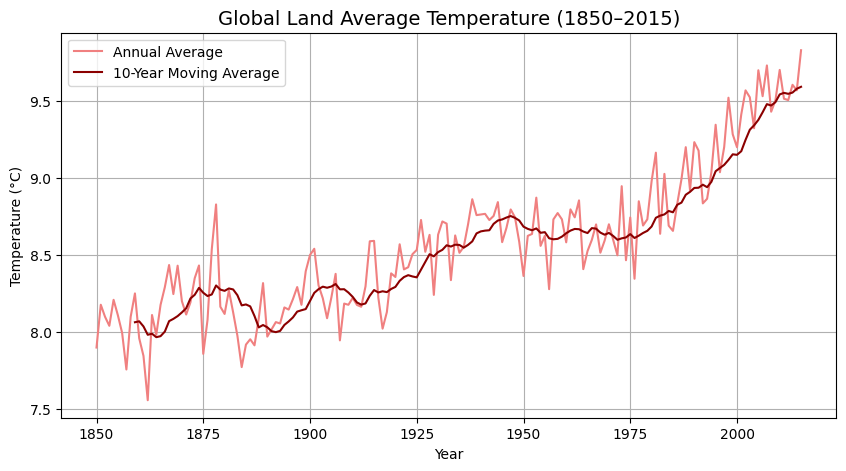

In [6]:
# Global Temperature Trend
plt.figure(figsize=(10,5))
sns.lineplot(x='Year', y='LandAverageTemperature', data=annual_global, label='Annual Average', color='lightcoral')
sns.lineplot(x='Year', y='10yr_avg', data=annual_global, label='10-Year Moving Average', color='darkred')

plt.title('Global Land Average Temperature (1850–2015)', fontsize=14)
plt.ylabel('Temperature (°C)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

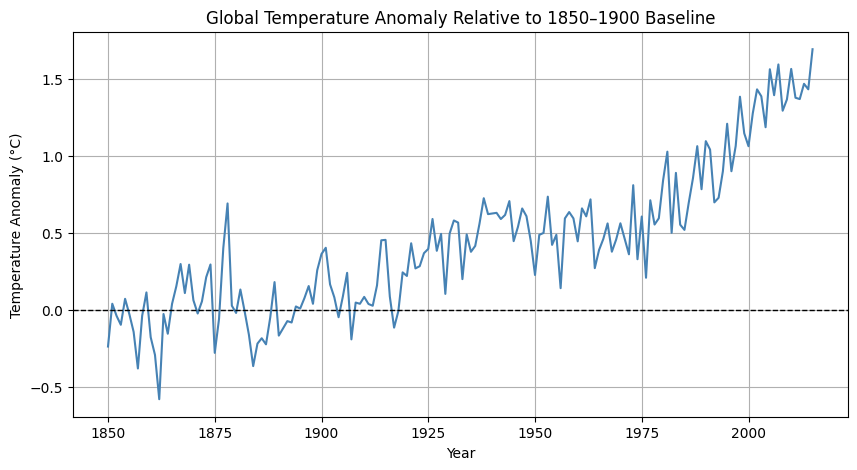

In [7]:
# Global Temperature Anomaly
# Define baseline (average temperature between 1850 and 1900)
baseline = annual_global[(annual_global['Year'] >= 1850) & (annual_global['Year'] <= 1900)]['LandAverageTemperature'].mean()

# Compute anomaly
annual_global['Anomaly'] = annual_global['LandAverageTemperature'] - baseline

plt.figure(figsize=(10,5))
sns.lineplot(x='Year', y='Anomaly', data=annual_global, color='steelblue')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Global Temperature Anomaly Relative to 1850–1900 Baseline')
plt.ylabel('Temperature Anomaly (°C)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

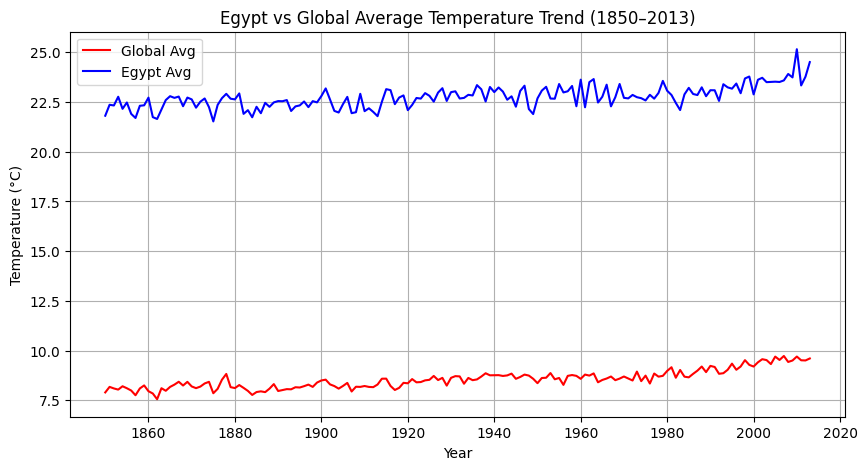

In [8]:
# Country vs. Global Comparison (e.g. Egypt)
country_name = 'Egypt'
egypt = annual_country[annual_country['Country'] == country_name]

# Merge Egypt and global data on year
merged = pd.merge(egypt, annual_global[['Year', 'LandAverageTemperature']], on='Year', how='inner')
merged.rename(columns={'AverageTemperature': f'{country_name}_Temp', 'LandAverageTemperature': 'Global_Temp'}, inplace=True)

plt.figure(figsize=(10,5))
sns.lineplot(x='Year', y='Global_Temp', data=merged, label='Global Avg', color='red')
sns.lineplot(x='Year', y=f'{country_name}_Temp', data=merged, label=f'{country_name} Avg', color='blue')
plt.title(f'{country_name} vs Global Average Temperature Trend (1850–2013)')
plt.ylabel('Temperature (°C)')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()